# Определение наиболее выгодного региона нефтедобычи

_____
**Описание исследования.**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.
_____
**Цель исследования.**

На основе данных геологи разведки выбрать район добычи нефти
_____
**Задачи исследования:**
- загрузка и подготовка данных;
- обучение и проверка модели;
- подготовка к расчету прибыли;
- расчет прибыли и рисков;
- вывод.


_____
**Исходные данные.**
    
  - `id` — уникальный идентификатор скважины;
  - `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
  - `product` — объём запасов в скважине (тыс. баррелей).
______



## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    mean_squared_error)

from numpy.random import RandomState

In [3]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
#напишем функцию, которая отобразит основную информацию для нашего датафрейма 
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.isnull().sum())
    display(data.describe(include='all').round(2))

In [5]:
#отобразим информацию для 0 региона
get_data_info(data_0)

,id,f0,f1,f2,product
91605,2WziL,0.744762,0.866772,4.206849,51.513360
93551,iwgbW,2.096032,0.572157,0.193223,73.691671
1931,ng4f5,-0.082337,0.910084,5.236881,97.434622
76673,FsyjT,-0.076606,1.051860,3.101331,38.304430
37734,c72MP,0.818788,-0.558951,2.100910,54.080756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
count,100000,100000.00,100000.00,100000.00,100000.00
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.50,0.25,2.50,92.50
std,NaN,0.87,0.50,3.25,44.29
min,NaN,-1.41,-0.85,-12.09,0.00
25%,NaN,-0.07,-0.20,0.29,56.50
50%,NaN,0.50,0.25,2.52,91.85
75%,NaN,1.07,0.70,4.72,128.56


In [6]:
#отобразим информацию для 1 региона
get_data_info(data_1)

,id,f0,f1,f2,product
77287,CNy9G,-5.626000,-7.412132,2.995365,84.038886
77219,YWN3V,-0.172317,-5.190414,-0.011260,3.179103
62841,Eiy7Y,10.150060,4.767119,5.003336,134.766305
11508,CEBuQ,-1.616699,-3.492354,0.999040,30.132364
4113,nwcf5,-4.716412,-1.107277,0.992708,30.132364


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
count,100000,100000.00,100000.00,100000.00,100000.00
unique,99996,NaN,NaN,NaN,NaN
top,wt4Uk,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.14,-4.80,2.49,68.83
std,NaN,8.97,5.12,1.70,45.94
min,NaN,-31.61,-26.36,-0.02,0.00
25%,NaN,-6.30,-8.27,1.00,26.95
50%,NaN,1.15,-4.81,2.01,57.09
75%,NaN,8.62,-1.33,4.00,107.81


In [7]:
#отобразим информацию для 2 региона
get_data_info(data_2)

,id,f0,f1,f2,product
25421,raf1y,-1.042599,0.720405,8.760772,122.314802
33515,eiG0K,0.017278,2.385254,12.677558,158.485441
73523,FIC7B,-1.010400,-0.759518,2.564860,109.796954
48562,3xW9W,-1.164829,-1.608346,2.764756,79.730208
3683,nJL7T,-1.717380,-0.142498,-0.726871,40.034826


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
count,100000,100000.00,100000.00,100000.00,100000.00
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.00,-0.00,2.50,95.00
std,NaN,1.73,1.73,3.47,44.75
min,NaN,-8.76,-7.08,-11.97,0.00
25%,NaN,-1.16,-1.17,0.13,59.45
50%,NaN,0.01,-0.01,2.48,94.93
75%,NaN,1.16,1.16,4.86,130.60


In [8]:
#проверим таблиццы на явные дубликаты

data_0.duplicated().sum(), data_1.duplicated().sum(), data_2.duplicated().sum()

(0, 0, 0)



**После изучений основной информации таблиц можем сделать вывод:**
- в таблицах нет выбросов т.к. среднее примерно равно медиане;
- нет пропусков и явных дубликатов. 

Построим для каждой таблицы гистограммы




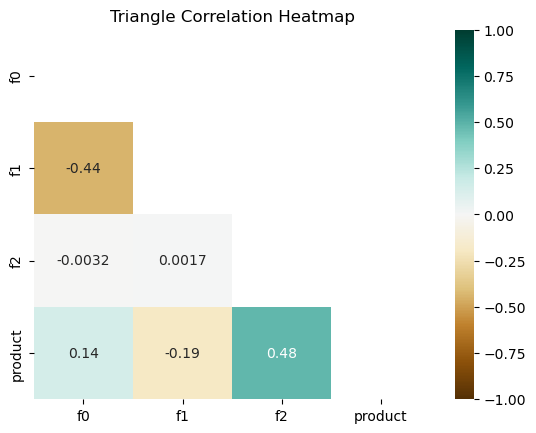

In [10]:
#Отобразим корреляцию столбцов в таблице 1

plt.figure() 
mask = np.triu(np.ones_like(data_0.corr(numeric_only=True), dtype=bool)) 
heatmap = sns.heatmap(data_0.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap');

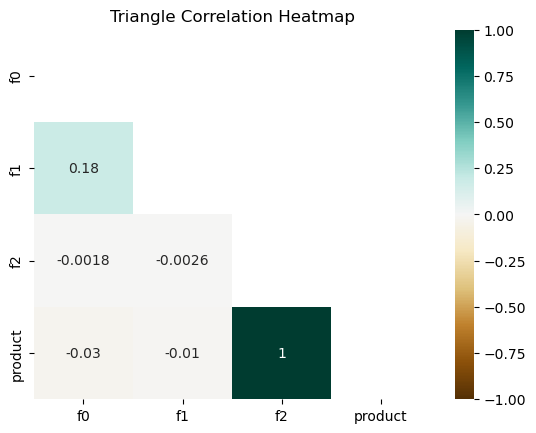

In [11]:
#Отобразим корреляцию столбцов в таблице 2

plt.figure() 
mask = np.triu(np.ones_like(data_1.corr(numeric_only=True), dtype=bool)) 
heatmap = sns.heatmap(data_1.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap');

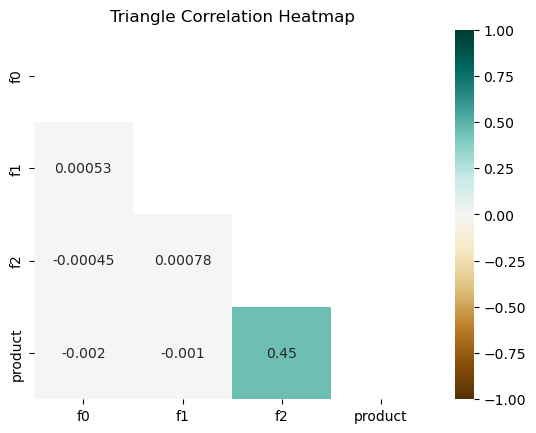

In [12]:
#Отобразим корреляцию столбцов в таблице 3

plt.figure() 
mask = np.triu(np.ones_like(data_2.corr(numeric_only=True), dtype=bool)) 
heatmap = sns.heatmap(data_2.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap');

**Во всех таблицах параметр `f2` сильно корелирует с параметром `product`. При этом если в 1 и 3 таблицах значение корреляции равно 0.45-0.48, то во 2 таблице столбы имеют коэффициент корреляции Пирсона =1 т.е. по шкале Чеддока связь весьма высокая**

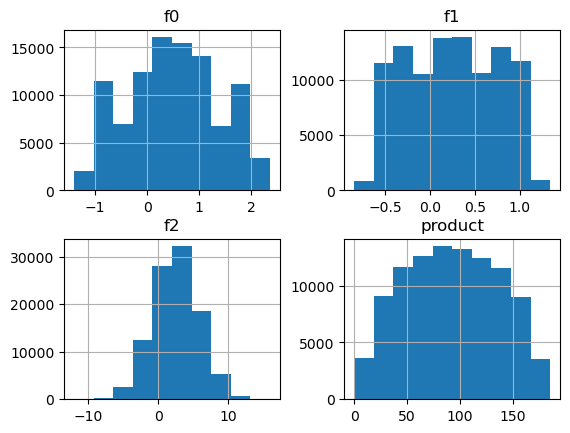

In [13]:
#Отобразим с помощью графиков как распределены значения в столбцах в таблице 1

data_0.hist()
plt.show()

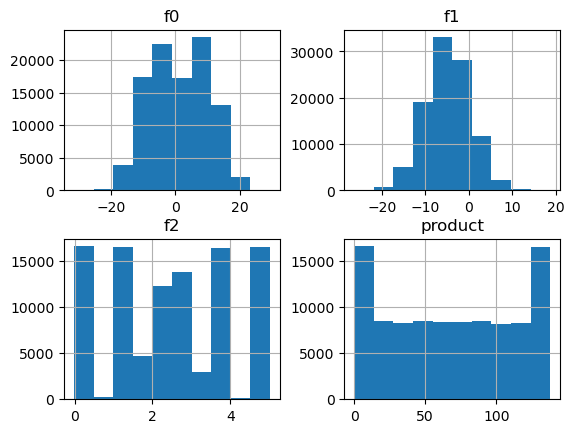

In [14]:
#Отобразим с помощью графиков как распределены значения в столбцах в таблице 2

data_1.hist()
plt.show()

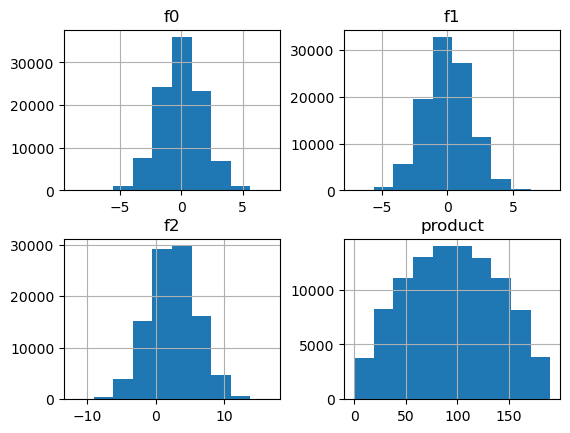

In [15]:
#Отобразим с помощью графиков как распределены значения в столбцах в таблице 3

data_2.hist()
plt.show()

Можем заметить, что в таблице №2 параметры `f2` и `product` распредели не нормально. и наглядно показывает, как они между собой коррелируют 

## Обучение и проверка модели

Обучим и проверем модель для каждого региона:


In [16]:
''' 
напишем функцию, которая:
- разделит данные на обучающую и валидационную выборки в соотношении 75:25;
- обучит модель и сделает предсказания на валидационной выборке.
'''
def model_lr(data):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=0.25, random_state=12345)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    # посчитаем средний предсказанного запас сырья
    predicted_valid_mean = sum(predictions_valid)/len(predictions_valid)
    
    return target_valid, predictions_valid, rmse, predicted_valid_mean
    
    
    
    

In [17]:
#Сохраниv предсказания и правильные ответы на валидационной выборке
target_valid_0, predictions_valid_0, rmse_0, predicted_valid_mean_0 = model_lr(data_0)
target_valid_1, predictions_valid_1, rmse_1, predicted_valid_mean_1 = model_lr(data_1)
target_valid_2, predictions_valid_2, rmse_2, predicted_valid_mean_2 = model_lr(data_2)

In [18]:
#напечатаем на экране средний запас предсказанного сырья и RMSE модели.
print(f'средний запас предсказанного сырья для 1 таблицы {predicted_valid_mean_0:.2f}, RMSE модели {rmse_0:.2f}')
print(f'средний запас предсказанного сырья для 2 таблицы {predicted_valid_mean_1:.2f}, RMSE модели {rmse_1:.2f}')
print(f'средний запас предсказанного сырья для 3 таблицы {predicted_valid_mean_2:.2f}, RMSE модели {rmse_2:.2f}')

средний запас предсказанного сырья для 1 таблицы 92.59, RMSE модели 37.58
средний запас предсказанного сырья для 2 таблицы 68.73, RMSE модели 0.89
средний запас предсказанного сырья для 3 таблицы 94.97, RMSE модели 40.03


## Подготовка к расчёту прибыли

In [19]:
#все ключевые значения для расчётов сохраним в отдельных переменных.
budget = 10 * 10**9
total_researches = 500
best_researches = 200
revenue_per_barrel = 450
revenue_per_product = 450 * 10**3
budget_1_researches = budget / best_researches

In [20]:
#Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

min_amount = budget/(revenue_per_product * best_researches)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины {min_amount:.2f} (тыс. баррелей)')

Достаточный объём сырья для безубыточной разработки новой скважины 111.11 (тыс. баррелей)


In [21]:
#Сравним полученный объём сырья со средним запасом в 0 регионе
predicted_valid_mean_0 - min_amount

-18.518543326731034

In [22]:
#Сравним полученный объём сырья со средним запасом в 1 регионе
predicted_valid_mean_1 - min_amount

-42.38256421566534

In [23]:
#Сравним полученный объём сырья со средним запасом во 2 регионе
predicted_valid_mean_2 - min_amount

-16.146065143106057

На данном этапе результаты не утешительные. средний запас предсказанного сырья ни в одном регионе не превышает достаточный объём сырья для безубыточной разработки. Во 2 регионе разница больше, чем в других.

## Расчёт прибыли и рисков 

In [24]:
#перед началом работы приведем необходимые нам столбцы к типу Series
def help_index(target, predictions):
    target = target.reset_index(drop=True)
    predictions = pd.Series(predictions)
    return target, predictions

In [25]:
target_valid_0, predictions_valid_0 = help_index(target_valid_0, predictions_valid_0)
target_valid_1, predictions_valid_1 = help_index(target_valid_1, predictions_valid_1)
target_valid_2, predictions_valid_2 = help_index(target_valid_2, predictions_valid_2)

In [26]:
#Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

def revenue(target, predictions):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:best_researches]
    return (sum(selected) * revenue_per_product) - budget

In [27]:
print(f'Прибыль для скважин с максимальными значениями предсказаний для региона 0: {revenue(target_valid_0, predictions_valid_0):.2f}')
print(f'Прибыль для скважин с максимальными значениями предсказаний для региона 1: {revenue(target_valid_1, predictions_valid_1):.2f}')
print(f'Прибыль для скважин с максимальными значениями предсказаний для региона 2: {revenue(target_valid_2, predictions_valid_2):.2f}')

Прибыль для скважин с максимальными значениями предсказаний для региона 0: 3320826043.14
Прибыль для скважин с максимальными значениями предсказаний для региона 1: 2415086696.68
Прибыль для скважин с максимальными значениями предсказаний для региона 2: 2710349963.60


Посчитаем риски и прибыль для каждого региона:
- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 
- распишем выводы: предложим регион для разработки скважин с обоснованием выбора.

In [28]:
def get_bootstrap(target, probabilities, number):
    state = np.random.RandomState(12345)
   
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=total_researches, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample))

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    
    mean = values.mean()
    risk = len(values[values<0]) / len(values) * 100
    print(f'Средняя выручка для региона {number}: {mean:.0f}')
    print(f'2.5%-квантиль: {lower:.0f}')
    print(f'97.5%-квантиль: {upper:.0f}')
    print(f'Риски: {risk:.0f}%')

In [29]:
get_bootstrap(target_valid_0, predictions_valid_0, 0)

Средняя выручка для региона 0: 425938527
2.5%-квантиль: -102090095
97.5%-квантиль: 947976353
Риски: 6%


In [30]:
get_bootstrap(target_valid_1, predictions_valid_1, 1)

Средняя выручка для региона 1: 515222773
2.5%-квантиль: 68873225
97.5%-квантиль: 931547591
Риски: 1%


In [31]:
get_bootstrap(target_valid_2, predictions_valid_2, 2)

Средняя выручка для региона 2: 435008363
2.5%-квантиль: -128880547
97.5%-квантиль: 969706954
Риски: 6%


### Вывод

По результатам исследования мы можем предложить 1 регион для разработки скважин т.к.:
1. средняя выручка в этом регионе показывает результаты выше, чем в соседних - 515222773 рублей ;
2. с вероятностью 97.5% выручка может быть не менее 68873225 рублей;
3. В данном решионе самый низкий риск - 1%